<a href="https://colab.research.google.com/github/psukphranee/Python-Practice/blob/master/SAR_scratch_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import math
import os
import scipy.sparse as sp

#A. Pulse Train Generating Functions

```generate_LFM_Pulse(time_array, pulse_width, pulse_height, chirp_rate, carrier_frequency)```

### $P(t) = \chi_{\tau}(t) e^{j 2 \pi (f_c t + \frac{1}{2}k t^2)}$. (cite Cheney Here)

$\chi_{\tau}(t)$ piecewise function describing pulse envelope

$f_c$ = carrier frequency

$k$ = chirp rate

##0. Dummy Variables and Utility Functions
Variables used for demo's.

In [2]:
def plot_train(time_absolute, time_modulus, train):

  fig, ax = plt.subplots(2,1, figsize=(20,8))
  ax[0].plot(t[0,:], train[0,:], alpha=0.5)
  ax[1].plot(t[0,:], t_mod[0,:], alpha=0.5)

  # ax[0].set_title("Pulse Envelope")
  ax[1].set_title("Verify Periodicity")
  plt.show()

In [319]:
#create time vector
t = np.linspace(0, 1, 800).reshape(1,-1)

#pulse train parameters
A = 1; #pulse height

k = 0000; #chirp rate
f_c = 1/.05; #carrier freq

D = .2 #duty time
PRF = 4. #Hz
PRT = np.reciprocal(PRF) #Pulse repetition period
tau = D*PRT; #duty_time/pulse width

#prepreocess time vector to make periodic
t_mod = t % PRT

##1. Pulse Envelope Train Helper Function

Generate a pulse (or pulses) of specified height and width. Pulse(s) have their left edge at time values of 0. The number of pulses generated depend on the time vector that is passes. To generate multiple pulses, preprocess the time vector by modulus division.

In [280]:
def generate_pulse_envelope(time_array, pulse_width=1, pulse_height=1):
  #this function returns pulse envelopes of tau width wide. the left edge of the envelope is located at any zeros of the time array.

  t = time_array;
  A = pulse_height;
  tau = pulse_width; 
  tau_half = tau/2;

  chi = A * (np.abs((t-tau_half)/tau_half) <= 1);

  return chi;

###a. Demo

Demonstrate the functions output. The input time vector is periodic as a result of modulus division.

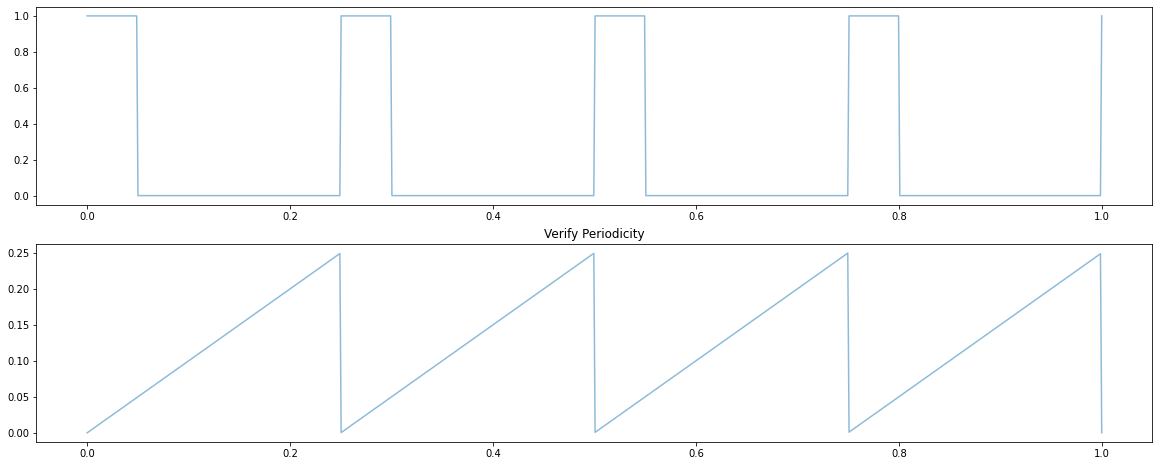

In [301]:
envelope_train = generate_pulse_envelope(t_mod, pulse_width=tau, pulse_height=A)
plot_train(t, t_mod, envelope_train)

##2. Pulse Wave Train Helper Function

In [265]:
def generate_pulse_wave(time_array, chirp_rate=1, carrier_frequency=100):
  #time ---------------
  t = time_array #expected time vector should be preprocessed before passed to this function. pulse and envelope start their sequences at times values of zeros.

  #LFM  ---------------
  k = chirp_rate
  f_c = carrier_frequency
  # #argument to be passed to exponenetial 
  exp_arg = 2j*np.pi*(f_c*t + .5*k*(np.square(t)))
  LFM = np.exp(exp_arg);

  return LFM

###a. Demo

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


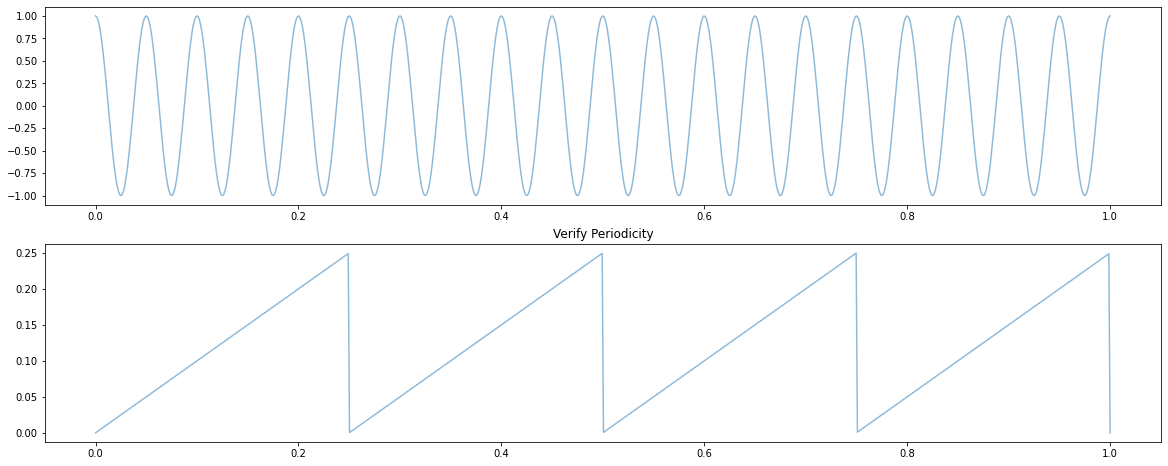

In [320]:
wave_train = generate_pulse_wave(t_mod, chirp_rate=k, carrier_frequency=f_c)
plot_train(t, t_mod, wave_train)

##3. LFM Pulse: Product of Previous Functions

In [8]:
def generate_LFM_Pulse(time_array, pulse_width=1, pulse_height=1, chirp_rate=1, carrier_frequency=100):
  
  #time ---------------
  t = time_array #expected time vector should be preprocessed before passed to this function. pulse and envelope start their sequences at times values of zeros.

  #pulse envelope  ---------------
  chi = generate_pulse_envelope(t, pulse_height=pulse_height, pulse_width=pulse_width);

  #LFM  ---------------
  k = chirp_rate
  f_c = carrier_frequency

  LFM = generate_pulse_wave(t, k, f_c)

  pulse = chi * LFM;

  return pulse

###a. Demo

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


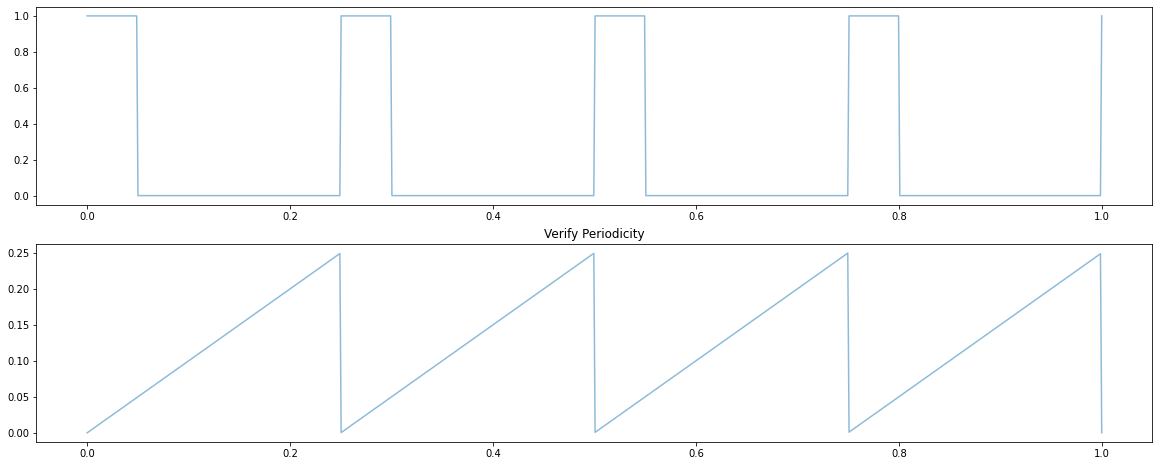

In [309]:
pulse = generate_LFM_Pulse(time_array=t_mod, pulse_width=tau, pulse_height=A, chirp_rate=k, carrier_frequency=f_c)
plot_train(t, t_mod, pulse)

#B. Geometry of Problem

##1. Matrix Representing Ground Swath

a. Let a matrix of 1D represent the ground swathed. The first element represents closest to radar and final element the furthest.

* $position = [p_0, p_1, ..., p_{n-1}]$

b. Each element is associated with some travel time. 

* $t_{travel} = [t_0, t_1, ..., t_{n-1}]$

c. For the purposes on convolution, we only care about the differences in travel time and therefore make them relative to $t_0$. $t_{travel} ⇒ t_{delay}$.

* $t_{delay} = [0, \Delta t_1, \Delta t_2, ..., \Delta t_{n-1}]$

d. Simplify by assuming time differences are all the same, $\Delta t$. Therefore,

* $t_{delay} = [0, \Delta t, 2 Δ t, ..., (n-1) Δt]$

###a. Time Delay

In [26]:
delta_tg = .05; #time delay steps correponding to ground element spacing
n_g = 20; #number of ground elements

t_delay = np.linspace(0, n_g-1, n_g).reshape(1,-1);
t_delay = t_delay * delta_tg; #time delay of each ground element wrt to first element
print(t_delay)

[[0.   0.05 0.1  0.15 0.2  0.25 0.3  0.35 0.4  0.45 0.5  0.55 0.6  0.65
  0.7  0.75 0.8  0.85 0.9  0.95]]


#C. Convolution

The system response is the superposition of delayed signals of our pulse train. 

$\sum_\limits{k=0}^{n_g} P({t - {{n_g}\Delta t_g}})$.

We need to sample and sum the corresponding parts of the pulse. We do this by selecting the indices of the pulse train corresponding to each time delay.

We can get these corresponding indices by scaling the time delay by the pulse train time steps.

$index_k = \dfrac{k \Delta t_g}{\Delta t_p}$, where $\Delta t_p$ are pulse time steps.

The result is the sum of shifted Identity matrices. The process is outlined as below.

##1. Create an identity matrix correpsonding to the number of ground elements. Create a matrix to represent the convolution. 

In [11]:
#define an identity matrix of size n_g (the number of ground elements)
I_ng = np.eye(n_g)
#The identity matrix will be shifted, summed and stored in the following matrix
Convolution_Matrix = np.zeros((I_ng.shape[0], I_ng.shape[0]))

###2. Scale the time delay vector

Convert the time delay into indices delay. The indices in the result correspond to indices in the pulses time vector. There may be redundant indices because the delay steps may be finer than the pulse time steps.

$\Delta s$ is the time step of the pulse.

In [27]:
Ds = t[0,1] - t[0,0]; #calculate this using the time matrix defined above. Using two points will suffice.

t_index_delay = (t_delay/Ds).astype('int') #this is a vector of indices corresponding to the time delay. We see that indices may repeat because the delay steps may be finer than the pulse time steps.
print(t_index_delay)

[[0 0 1 1 2 2 3 3 4 4 5 5 6 6 7 7 8 8 9 9]]


In [30]:
def delay_to_index(num_elements, delay_step_size, pulse_step_size):
  n_g = num_elements
  Ds = pulse_step_size
  delta_tg = delay_step_size

  t_delay = np.linspace(0, n_g-1, n_g).reshape(1,-1);
  t_delay = t_delay * delta_tg;

  t_index_delay = (t_delay/Ds).astype('int')

  return t_index_delay

###3. Generate the Convolution Matrix

The above indices determine how much to left shift the identity matrix by. We shift and then sum them into the matrix representing the convolution operation. We return the lower triangular entries since shifting rotates entries instead of padding with zeros.

In [73]:
for i in range(0, n_g):

    curr_delay_index = t_index_delay[0, i]
    curr_delay_index = curr_delay_index if curr_delay_index < n_g else 0 #limit shifting to convolution window limit. otherwise we can get redundant or unwanted values
    # print(curr_index_delay)
    Convolution_Matrix = Convolution_Matrix + np.roll(I_ng, curr_delay_index * -1, axis=1) #shift left

Convolution_Matrix = np.tril(Convolution_Matrix)

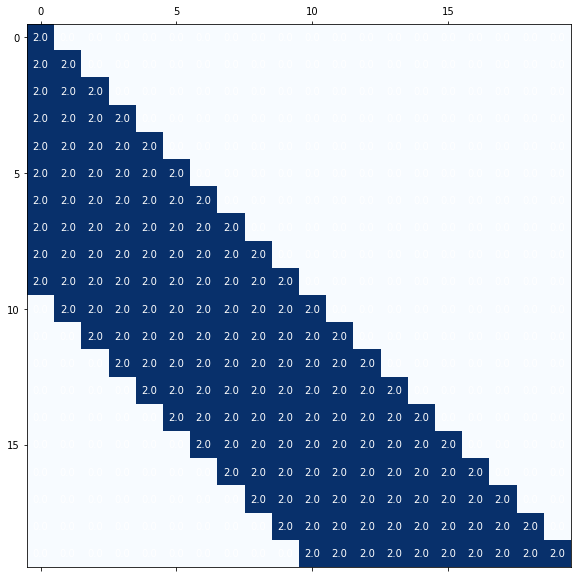

In [15]:
fig, ax = plt.subplots(figsize=(10,10))

ax.matshow(Convolution_Matrix, cmap=plt.cm.Blues)

for i in range(Convolution_Matrix.shape[0]):
    for j in range(Convolution_Matrix.shape[1]):
        c = Convolution_Matrix[j,i]
        ax.text(i, j, str(c), va='center', ha='center', color="white")

###4. Define as a Function

In [98]:
def generate_Convolution_Matrix(window_size, index_shift_vector):
  print("generate_Convolution_Matrix")

  n_g = window_size;
  t_index_delay = index_shift_vector

  #define an identity matrix of size n_g (the number of ground elements)
  I_ng = np.eye(n_g)
  # print("Identity Matrix")
  # print(I_ng)

  # print("delay indices")
  # print(t_index_delay)
  #The identity matrix will be shifted, summed and stored in the following matrix
  Convolution_Matrix = np.zeros((I_ng.shape[0], I_ng.shape[0]))
  # print("C: ")
  # print(Convolution_Matrix)

  for i in range(0, n_g):
    curr_delay_index = t_index_delay[0, i]
    # print("curr_index_delay_before: ", curr_delay_index)
    if(curr_delay_index >= n_g): #limit shifting to convolution window limit. otherwise we can get redundant or unwanted values
      # print("Pass")
      continue 
    # print("curr_index_delay_after: ", curr_delay_index)
    Convolution_Matrix = Convolution_Matrix + np.roll(I_ng, curr_delay_index * -1, axis=1) #shift left
    # print("C: ")
    # print(Convolution_Matrix)

  Convolution_Matrix = np.tril(Convolution_Matrix)

  return Convolution_Matrix

In [20]:
def plot_convolution_matrix(matrix):
  fig, ax = plt.subplots(figsize=(10,10))

  ax.matshow(matrix, cmap=plt.cm.Blues)

  for i in range(matrix.shape[0]):
      for j in range(matrix.shape[1]):
          c = matrix[j,i]
          ax.text(i, j, str(c), va='center', ha='center', color="white")

####a. Demo

generate_Convolution_Matrix


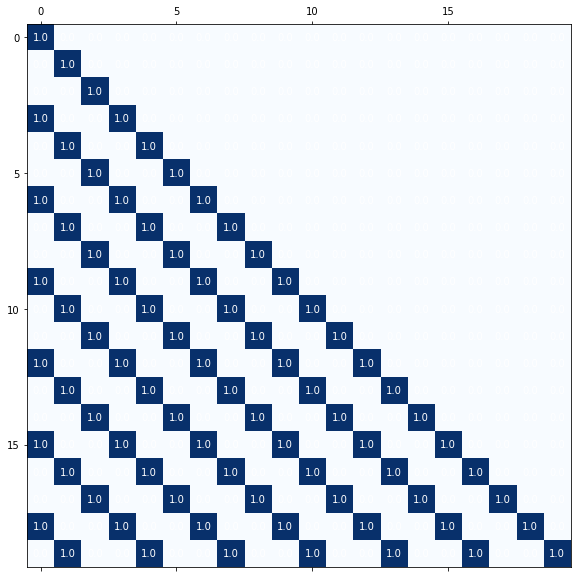

In [102]:
t_delay = delay_to_index(num_elements=20, delay_step_size=3, pulse_step_size=1) 
Conv_Mat = generate_Convolution_Matrix(window_size=n_g, index_shift_vector=t_delay)
plot_convolution_matrix(Conv_Mat)


#D. Demonstrate Impulse Repsonse of Ground Reflection



##1. Generate Pulse Train

In [256]:
# #pulse train parameters
# A = 1; #pulse height

# k = 0000; #chirp rate
# f_c = 1#3/.05; #carrier freq

# D = .2 #duty time
# PRF = 4. #Hz
# PRT = np.reciprocal(PRF) #Pulse repetition period
# tau = D*PRT; #duty_time/pulse width

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


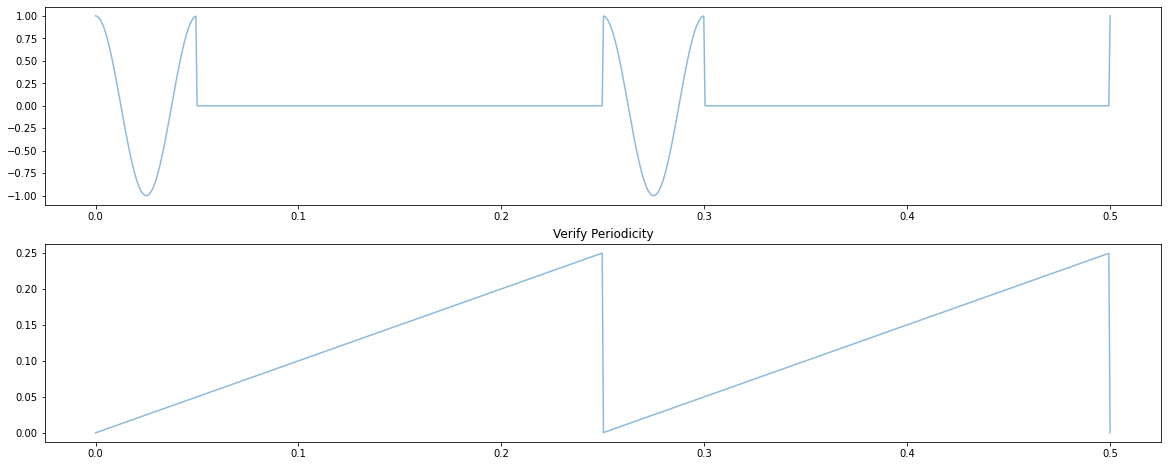

In [323]:
#create time vector
t = np.linspace(0, .5, 800).reshape(1,-1)
#prepreocess time vector to make periodic
t_mod = t % PRT

#pulse
P = generate_LFM_Pulse(time_array=t_mod, pulse_height=A, pulse_width=tau, chirp_rate=k, carrier_frequency=f_c)

#plot
plot_train(t, t_mod, P)

ds =  0.000625
generate_Convolution_Matrix


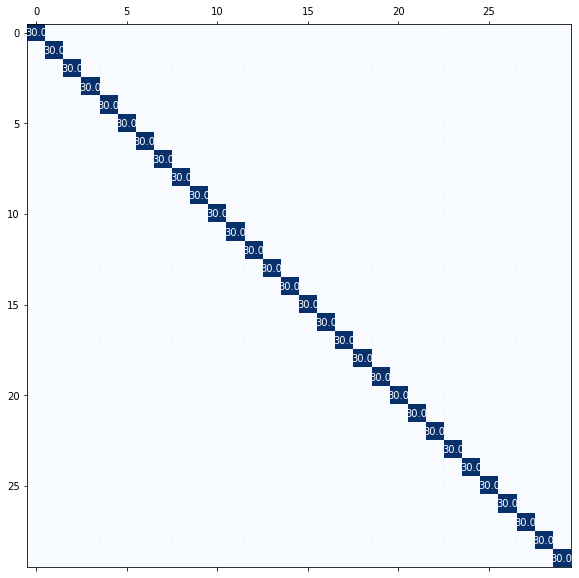

In [313]:
n_g = 30 #number of ground elements > 1
dg = 0#4./800 #ground time step size
ds = .5/800 #pulse time step size
print("ds = ", ds)
t_delay = delay_to_index(num_elements=n_g, delay_step_size=dg, pulse_step_size=ds) 

Conv_Mat = generate_Convolution_Matrix(window_size=n_g, index_shift_vector=t_delay)
plot_convolution_matrix(Conv_Mat)

In [324]:
window = Conv_Mat.shape[0]
t_ = t.shape[0] - window
response = np.linspace(0, P.shape[1]-n_g-1, P.shape[1]-n_g).reshape(1,-1)

for i in range(response.shape[1]):
  response[0,i] = np.sum(np.matmul(Conv_Mat, P[0,i:i+window].transpose()))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: ComplexWarning: Casting complex values to real discards the imaginary part
  


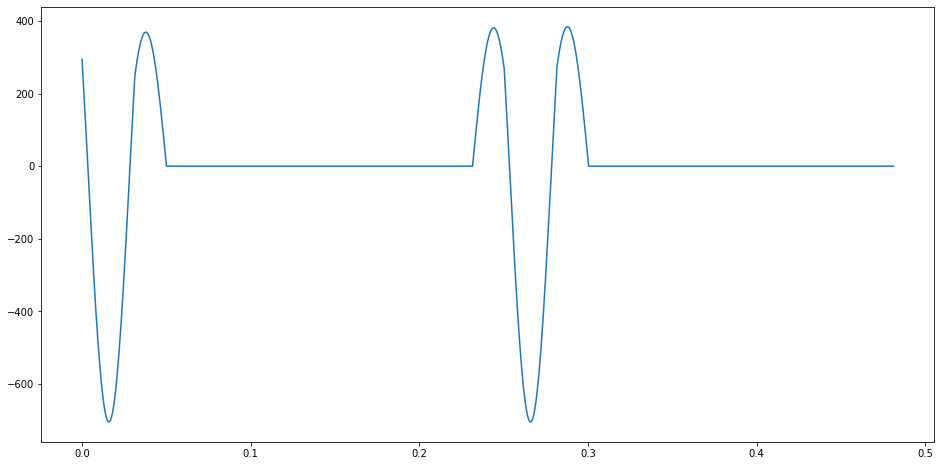

In [325]:
plt.figure(figsize=(16,8))
plt.plot(t[0,:t_-1], response[0,:])